In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/perspred/mbti_1.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import RegexpTokenizer
import string 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
import wordcloud
pd.set_option('max_rows',1000000)
pd.set_option('max_columns',10000)
sns.set(rc={'figure.figsize':(15,10)})
import spacy

In [4]:
df = pd.read_csv('/kaggle/input/perspred/mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


Exploratory Data Analysis


In [7]:
gr = df.groupby('type').count()
gr.sort_values("posts", ascending=False, inplace=True)
gr

,posts
type,
INFP,1832
INFJ,1470
INTP,1304
INTJ,1091
ENTP,685
ENFP,675
ISTP,337
ISFP,271
ENTJ,231


**plotting the count**

<AxesSubplot:title={'center':'Number of Posts per Personality type'}, xlabel='type'>

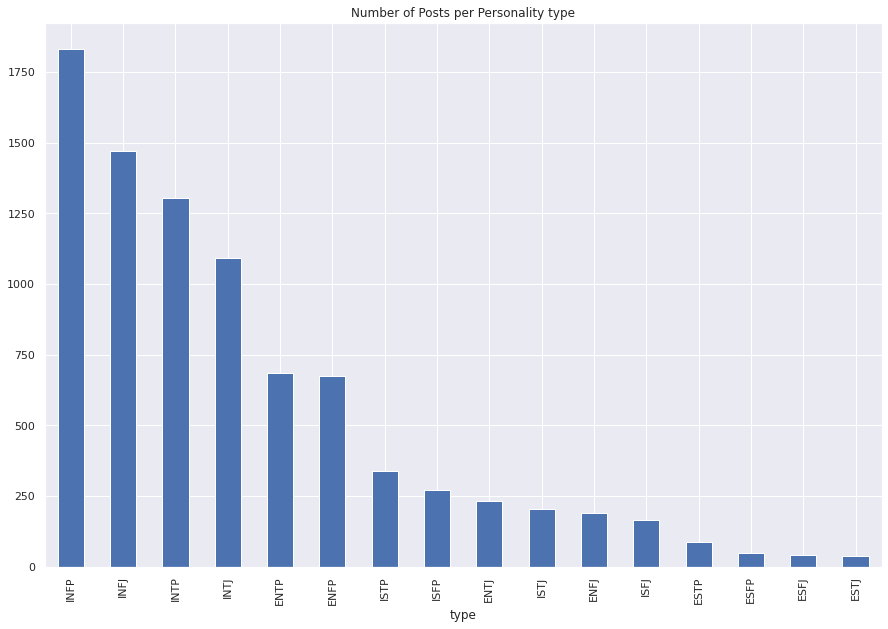

In [8]:
plt.figure(figsize=(15,10))
gr['posts'].plot(kind='bar',title="Number of Posts per Personality type")

**distribution length of all posts**


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


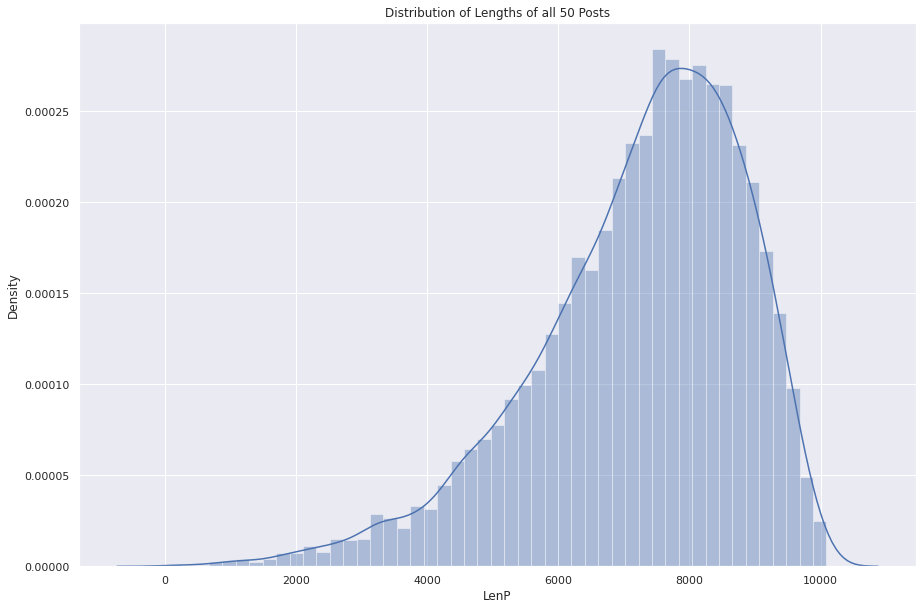

In [10]:
df["LenP"] = df["posts"].apply(len)
sns.distplot(df["LenP"]).set_title("Distribution of Lengths of all 50 Posts");

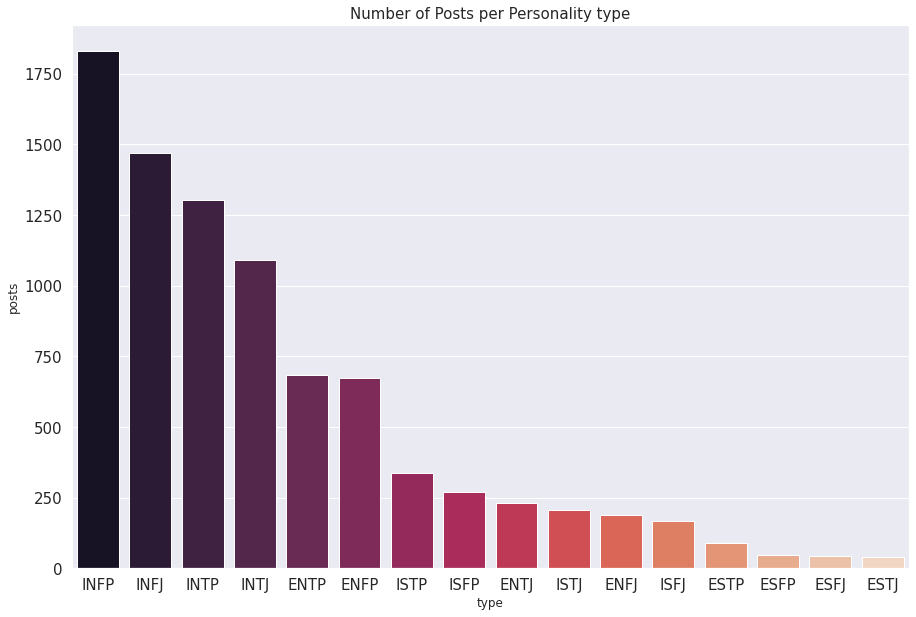

In [12]:
sns.barplot(x=gr.index,y='posts',data=gr,palette='rocket')
plt.title('Number of Posts per Personality type',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

**plotting no.of posts per user**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of Posts per User')

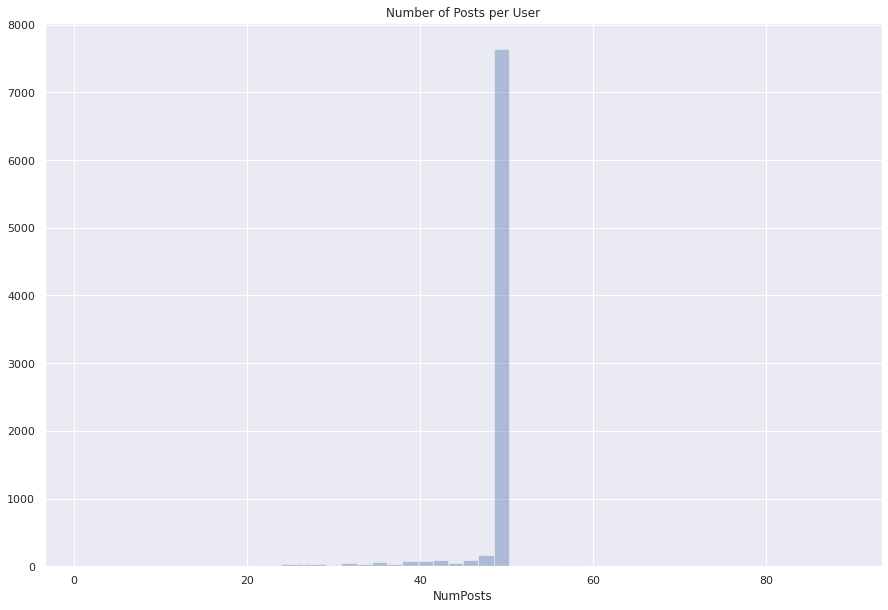

In [13]:
df["NumPosts"] = df["posts"].apply(lambda x: len(x.split("|||")))

sns.distplot(df["NumPosts"], kde=False).set_title("Number of Posts per User")

In [14]:
df.head()

,type,posts,LenP,NumPosts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,4652,50
1,ENTP,'I'm finding the lack of me in these posts ver...,7053,50
2,INTP,'Good one _____ https://www.youtube.com/wat...,5265,50
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",6271,50
4,ENTJ,'You're fired.|||That's another silly misconce...,6111,50


In [15]:
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))

Number of users 8675
Number of posts 422845


In [16]:
posts

[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.'),
 ('INFJ', 'May the PerC Experience immerse you.'),
 ('INFJ',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206'),
 ('INFJ',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as..."),
 ('INFJ',
  '84389  84390  http://wallpaperpassion.com/upload/23700/

In [17]:
new_df = pd.DataFrame(posts, columns=["type", "posts"])
new_df.head(100)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...
5,INFJ,May the PerC Experience immerse you.
6,INFJ,The last thing my INFJ friend posted on his fa...
7,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...
8,INFJ,84389 84390 http://wallpaperpassion.com/uplo...
9,INFJ,Welcome and stuff.


**find most common words in all posts**

In [18]:
words = list(new_df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)

[('I', 463694),
 ('to', 290296),
 ('the', 271111),
 ('a', 231152),
 ('and', 219676),
 ('of', 177901),
 ('you', 129537),
 ('is', 128915),
 ('that', 127521),
 ('in', 117384),
 ('my', 105005),
 ('it', 93656),
 ('for', 83151),
 ('have', 79840),
 ('with', 77180),
 ('but', 74834),
 ("I'm", 70560),
 ('be', 69359),
 ('are', 65107),
 ('like', 61449),
 ('not', 59700),
 ('an', 59057),
 ('on', 57126),
 ('was', 56169),
 ('me', 55821),
 ('as', 53400),
 ('this', 53053),
 ('just', 48449),
 ('about', 46334),
 ('think', 46270),
 ('or', 45764),
 ("don't", 44885),
 ('so', 43189),
 ('do', 40994),
 ('your', 40991),
 ('what', 38089),
 ('at', 37604),
 ('can', 37600),
 ('if', 37254),
 ('people', 35673)]

**plotting most common words with wordcloud**

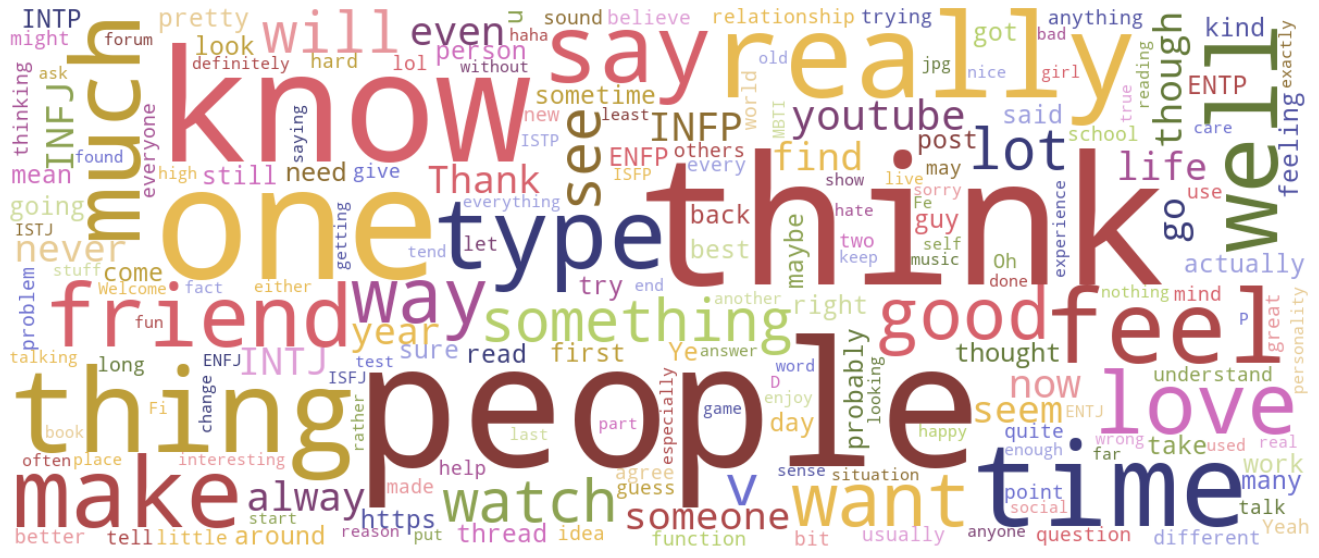

In [19]:
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))
plt.figure(figsize=(25,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

In [22]:
def preprocess_text(df, remove_special=True):
    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep EOS
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))
    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #To lower
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove short/long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove Personality Types Words
    #This is crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    df["posts"] = df["posts"].apply(lambda x: p.sub(' PTypeToken ',x))
    return df


**MODELLING**

In [23]:
#Remove posts with less than X words
min_words = 15
print("Number of posts", len(new_df)) 
new_df["nw"] = new_df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["nw"] >= min_words]
print("Number of posts", len(new_df))

Number of posts 422845
Number of posts 324407


**encoding personality types**

In [24]:
enc = LabelEncoder()
new_df['type_enc'] = enc.fit_transform(new_df['type'])
target = new_df['type_enc']
target.head()

2    8
4    8
6    8
7    8
8    8
Name: type_enc, dtype: int64

In [25]:
new_df.head(100)

,type,posts,nw,type_enc
2,INFJ,enfp and intj moments https://www.youtube.com...,24,8
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,20,8
6,INFJ,The last thing my INFJ friend posted on his fa...,23,8
7,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,38,8
8,INFJ,84389 84390 http://wallpaperpassion.com/uplo...,26,8
10,INFJ,http://playeressence.com/wp-content/uploads/20...,20,8
11,INFJ,"Prozac, wellbrutin, at least thirty minutes of...",34,8
12,INFJ,Basically come up with three items you've dete...,34,8
13,INFJ,All things in moderation. Sims is indeed a vi...,38,8
14,INFJ,Dear ENFP: What were your favorite video game...,20,8


**vectorizing posts**

In [26]:
vect = CountVectorizer(stop_words='english') 
train =  vect.fit_transform(new_df["posts"])

In [27]:
train.shape

(324407, 118210)

**splitting data**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.1, stratify=target, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(291966, 118210) (32441, 118210) (291966,) (32441,)


**training model**

In [29]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
accuracy_score(y_test,xgb.predict(X_test))

0.285410437409451